<a href="https://colab.research.google.com/github/Kusakawama/MADS_CNN/blob/main/ConceptSHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [1]:
!pip install tf-keras-vis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 1.6 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.scores import CategoricalScore
from keras.models import Model
import cv2
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_hub as hub
from tensorflow_datasets.core import lazy_builder_import

## Data Loading

In [3]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle-2.json
! kaggle datasets list

Saving kaggle.json to kaggle.json
chmod: cannot access '/root/.kaggle/kaggle-2.json': No such file or directory
ref                                                          title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
haseebindata/student-performance-predictions                 Student Performance Predictions                      9KB  2024-08-17 06:57:57           2665         62  0.9411765        
berkayalan/paris-2024-olympics-medals                        Paris 2024 Olympics Medals                           1KB  2024-08-14 11:02:45           2976         55  1.0              
balajivaraprasad/crimes-against-women-in-india-2001-2021     Crimes Against Women in India (2001-2021)           13KB  2024-08-15 16:47:18           111

In [4]:
! kaggle datasets download abdelghaniaaba/wildfire-prediction-dataset

Dataset URL: https://www.kaggle.com/datasets/abdelghaniaaba/wildfire-prediction-dataset
License(s): other
 99% 1.43G/1.45G [00:18<00:00, 133MB/s]
100% 1.45G/1.45G [00:18<00:00, 81.9MB/s]


In [ ]:
  ! unzip wildfire-prediction-dataset.zip

In [6]:
! kaggle datasets download apollo2506/landuse-scene-classification

Dataset URL: https://www.kaggle.com/datasets/apollo2506/landuse-scene-classification
License(s): CC0-1.0
 99% 1.97G/1.98G [00:16<00:00, 124MB/s]
100% 1.98G/1.98G [00:16<00:00, 129MB/s]


In [ ]:
! mkdir -p concepts
! unzip landuse-scene-classification.zip -d concepts

In [8]:
class CustomDataGenerator(Sequence):
    def __init__(self, directory, batch_size=32, target_size=(224, 224), class_mode='categorical', shuffle=True):
        self.directory = directory
        self.batch_size = batch_size
        self.target_size = target_size
        self.class_mode = class_mode
        self.shuffle = shuffle

        self.classes = sorted(os.listdir(directory))
        self.class_indices = {cls: idx for idx, cls in enumerate(self.classes)}
        self.image_paths, self.labels = self._get_image_paths_and_labels()

        self.on_epoch_end()  # Shuffle the data if necessary

    def _get_image_paths_and_labels(self):
        image_paths = []
        labels = []
        for cls in self.classes:
            cls_dir = os.path.join(self.directory, cls)
            for img_name in os.listdir(cls_dir):
                if img_name.startswith('.'):  # Skip hidden files
                    continue
                image_paths.append(os.path.join(cls_dir, img_name))
                labels.append(self.class_indices[cls])
        return image_paths, labels

    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_image_paths = self.image_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]

        images = np.array([self._load_image_opencv(img_path) for img_path in batch_image_paths])
        labels = np.array(batch_labels)

        if self.class_mode == 'categorical':
            labels = tf.keras.utils.to_categorical(labels, num_classes=len(self.classes))

        return images, labels

    def on_epoch_end(self):
        if self.shuffle:
            combined = list(zip(self.image_paths, self.labels))
            np.random.shuffle(combined)
            self.image_paths, self.labels = zip(*combined)
            self.image_paths = list(self.image_paths)
            self.labels = list(self.labels)

    def _load_image_opencv(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        img = cv2.resize(img, self.target_size)  # Resize to target size
        img = img.astype('float32') / 255.0  # Normalize the image
        return img

# Usage:
train_generator = CustomDataGenerator('/content/train', batch_size=16, target_size=(224, 224))
val_generator = CustomDataGenerator('/content/valid', batch_size=16, target_size=(224, 224))

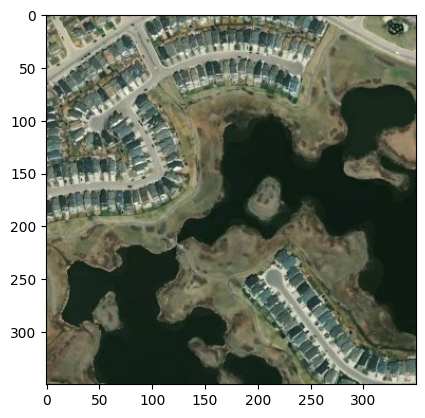

In [9]:
#test_img_path = "/content/test/wildfire/-59.03238,51.85132.jpg" #wildfire
test_img_path = "/content/test/nowildfire/-113.91777,50.901087.jpg" #nowildire
image = mpimg.imread(test_img_path)

# Plot the image
imgplot = plt.imshow(image)
#plt.xlabel("Wildfire")
#plt.xlabel("No Wildfire")
plt.show()

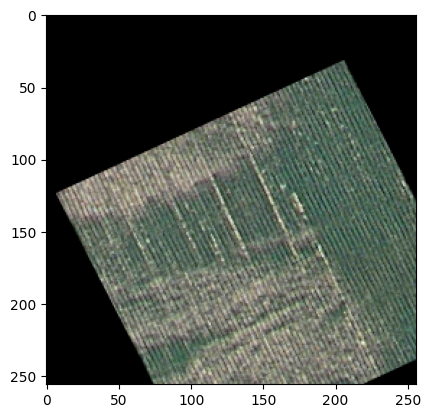

In [10]:
#test_img_path = "/content/test/wildfire/-59.03238,51.85132.jpg" #wildfire
test_img_path = "/content/concepts/images/agricultural/agricultural_000001.png" #agricultural
image = mpimg.imread(test_img_path)

# Plot the image
imgplot = plt.imshow(image)
#plt.xlabel("Wildfire")
#plt.xlabel("No Wildfire")
plt.show()

In [7]:
test_arr = []
test_image = cv2.imread(test_img_path)
test_image = cv2.resize(test_image,(224,224))
test_image = np.array(test_image)
test_image = test_image/255
test_image = test_image.reshape(1,224,224,3)
test_arr.append(test_image)

In [11]:
from tensorflow.keras.models import load_model

# Load the saved model
model2_loaded = load_model('resent50_finetuned_224.keras')

# Use the loaded model for inference or further training
#model2_loaded.evaluate(val_generator)

## Model for concept extraction

In [13]:
#module = hub.load("https://www.kaggle.com/models/google/resnet50/TensorFlow1/remote-sensing-bigearthnet-resnet50/1")

In [16]:

def preprocess_image(image_file_path_concepts):
    # Load the image
    img = cv2.imread(image_file_path_concepts)
    if img is None:
        print(f"Warning: Image at path {image_file_path_concepts} could not be loaded.")
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = cv2.resize(img, (224, 224))  # Resize to 224x224 as expected by ResNet50
    img = img.astype('float32') / 255.0  # Normalize to [0,1]
    return img

def load_concept_images(concepts_dir, batch_size=32):
    image_file_paths = []

    # Traverse through all the subdirectories and find image files
    for root, _, files in os.walk(concepts_dir):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):  # Only include valid image files
                image_file_paths.append(os.path.join(root, file))

    print(f"Found {len(image_file_paths)} images in {concepts_dir}.")

    # If no images are found, return early
    if len(image_file_paths) == 0:
        return []

    # Shuffle the image paths for randomness
    np.random.shuffle(image_file_paths)

    # Split into batches
    for i in range(0, len(image_file_paths), batch_size):
        batch_paths = image_file_paths[i:i + batch_size]
        batch_images = []
        for image_file_path_concepts in batch_paths:
            img = preprocess_image(image_file_path_concepts)
            if img is not None:
                batch_images.append(img)

        if len(batch_images) > 0:
            yield np.array(batch_images)

def extract_features(images):
    # Convert images to TensorFlow tensors before feature extraction
    images = tf.convert_to_tensor(images)

    # Extract features using the TensorFlow Hub module
    features = module(images)  # This will output the feature vectors
    return features

def extract_concepts_from_folder(concepts_dir, feature_extractor, batch_size=32):
    concept_features = []
    for image_batch in load_concept_images(concepts_dir, batch_size=batch_size):
        print(f"Processing batch of size: {image_batch.shape}")
        features = feature_extractor(image_batch)
        concept_features.append(features.numpy())  # Convert TensorFlow tensors to numpy arrays

    if len(concept_features) == 0:
        print("No concept features were extracted.")
        return np.array([])  # Return an empty array if nothing was processed

    return np.concatenate(concept_features, axis=0)

# Assuming you're working with the "train" or "test" folders under "images_train_test_val"
# Path to the extracted concept images from the Kaggle dataset
concepts_dir = "/content/concepts/images_train_test_val/train"  # Change to 'test' or 'validation' as needed

# Extract concept features from the Kaggle dataset
concept_features = extract_concepts_from_folder(concepts_dir, extract_features, batch_size=32)

print("Extracted concept features shape:", concept_features.shape)


Found 7350 images in /content/concepts/images_train_test_val/train.
Processing batch of size: (32, 224, 224, 3)


TypeError: 'AutoTrackable' object is not callable

Found 7350 images in /content/concepts/images_train_test_val/train.
Image batch shape: (32, 224, 224, 3)


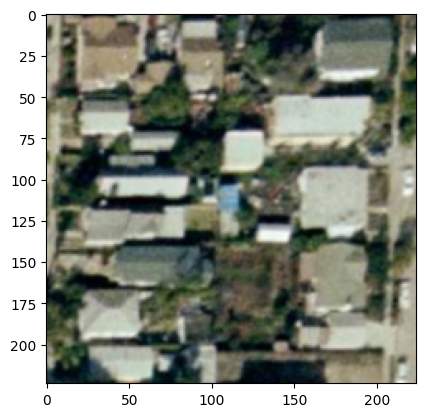

In [18]:
# Test image loading and preprocessing
concepts_dir = "/content/concepts/images_train_test_val/train"  # Adjust this path as necessary

# Load the first batch of images
image_batch = next(load_concept_images(concepts_dir, batch_size=32))

print(f"Image batch shape: {image_batch.shape}")

# Check one of the images
import matplotlib.pyplot as plt

plt.imshow(image_batch[0])
plt.show()

In [19]:
# Test feature extraction on the first image batch
try:
    features = extract_features(image_batch)
    print(f"Features shape: {features.shape}")
except Exception as e:
    print(f"Error during feature extraction: {e}")


Error during feature extraction: Exception encountered when calling FeatureExtractor.call().

'AutoTrackable' object is not callable

Arguments received by FeatureExtractor.call():
  • inputs=tf.Tensor(shape=(32, 224, 224, 3), dtype=float32)


In [26]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np

# Load the TensorFlow Hub model using hub.KerasLayer
module_url = "https://www.kaggle.com/models/google/resnet50/TensorFlow1/remote-sensing-bigearthnet-resnet50/1"  # Correct model URL from TF Hub
feature_extractor_layer = hub.KerasLayer(module_url, trainable=False)

# Generate a dummy batch of random images
dummy_images = np.random.rand(32, 224, 224, 3).astype(np.float32)

try:
    # Directly call the feature extractor layer
    features = feature_extractor_layer(dummy_images)
    print(f"Feature extraction successful. Features shape: {features.shape}")
except Exception as e:
    print(f"Error during direct feature extraction: {e}")

Feature extraction successful. Features shape: (32, 2048)


In [37]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import os
import cv2

# Load the TensorFlow Hub model using hub.KerasLayer
module_url = "https://www.kaggle.com/models/google/resnet50/TensorFlow1/remote-sensing-bigearthnet-resnet50/1"  # Correct model URL from TF Hub
feature_extractor_layer = hub.KerasLayer(module_url, trainable=False)

# Define the path to your image dataset
concepts_dir = '/content/concepts/images_train_test_val/train'  # Adjust based on your folder structure

# Function to load and preprocess images
def load_and_preprocess_images(concepts_dir, target_size=(224, 224), batch_size=32):
    image_paths = []

    # Traverse through the directory structure and collect image file paths
    for root, dirs, files in os.walk(concepts_dir):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(root, file))

    print(f"Found {len(image_paths)} images.")

    # Load and preprocess images
    images = []
    for img_path in image_paths[:batch_size]:  # Limit to batch_size images for this test
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        img = cv2.resize(img, target_size)  # Resize to target size
        img = img.astype('float32') / 255.0  # Normalize to [0,1]
        images.append(img)

    images = np.array(images)
    return images

# Load the actual images
real_images = load_and_preprocess_images(concepts_dir)

try:
    # Directly call the feature extractor layer on your real images
    features = feature_extractor_layer(real_images)
    print(f"Feature extraction successful. Features shape: {features.shape}")
except Exception as e:
    print(f"Error during feature extraction: {e}")


Found 7350 images.
Feature extraction successful. Features shape: (32, 2048)


In [31]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np

# Load the TensorFlow Hub model
module = hub.load("https://www.kaggle.com/models/google/resnet50/TensorFlow1/remote-sensing-bigearthnet-resnet50/1")

# Create a function to run the model directly
def extract_features(images):
    # Ensure the input is converted to a tensor
    images = tf.convert_to_tensor(images, dtype=tf.float32)

    # Call the module directly
    features = module.signatures['default'](images)

    # Return the relevant output; adjust if necessary based on available keys
    return features['default']  # We use 'default' as this is the main feature vector output

# Generate a batch of dummy images
dummy_images = np.random.rand(32, 224, 224, 3).astype(np.float32)

# Extract features for the batch
try:
    features = extract_features(dummy_images)
    print(f"Feature extraction successful. Features shape: {features.shape}")
except Exception as e:
    print(f"Error during feature extraction: {e}")


Feature extraction successful. Features shape: (32, 2048)


In [36]:
import tensorflow as tf
import numpy as np
import tensorflow_hub as hub

# Load the TensorFlow Hub model
module = hub.load("https://www.kaggle.com/models/google/resnet50/TensorFlow1/remote-sensing-bigearthnet-resnet50/1")

# Define a function to extract features
def extract_features(images):
    # Convert input to a tensor
    images = tf.convert_to_tensor(images, dtype=tf.float32)

    # Extract features from the model
    features = module.signatures['default'](images)

    return features['default']

# Generate a batch of dummy images
dummy_images = np.random.rand(32, 224, 224, 3).astype(np.float32)

# Extract the features (symbolic tensors)
features = extract_features(dummy_images)

# Now we use a TensorFlow session to evaluate the tensors
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())

    # Run the session to evaluate the features
    evaluated_features = sess.run(features)

    # Inspect the features
    print("Feature vector for first image:\n", evaluated_features[0])
    print("Mean of feature vectors:", np.mean(evaluated_features))
    print("Standard deviation of feature vectors:", np.std(evaluated_features))


Feature vector for first image:
 [3.2833545  0.11355454 0.         ... 0.         0.00552862 0.36756766]
Mean of feature vectors: 0.25134698
Standard deviation of feature vectors: 0.5626801


In [38]:
import tensorflow as tf
import numpy as np
import tensorflow_hub as hub
import cv2
import os

# Load the TensorFlow Hub model
module = hub.load("https://www.kaggle.com/models/google/resnet50/TensorFlow1/remote-sensing-bigearthnet-resnet50/1")

# Define a function to extract features
def extract_features(images):
    # Convert input to a tensor
    images = tf.convert_to_tensor(images, dtype=tf.float32)

    # Extract features from the model
    features = module.signatures['default'](images)

    return features['default']

# Define the path to your image dataset
concepts_dir = '/content/concepts/images_train_test_val/train'  # Adjust based on your folder structure

# Function to load and preprocess images
def load_and_preprocess_images(concepts_dir, target_size=(224, 224), batch_size=32):
    image_paths = []

    # Traverse through the directory structure and collect image file paths
    for root, dirs, files in os.walk(concepts_dir):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(root, file))

    print(f"Found {len(image_paths)} images.")

    # Load and preprocess images
    images = []
    for img_path in image_paths[:batch_size]:  # Limit to batch_size images for this test
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        img = cv2.resize(img, target_size)  # Resize to target size
        img = img.astype('float32') / 255.0  # Normalize to [0,1]
        images.append(img)

    images = np.array(images)
    return images

# Load the actual images from your dataset
real_images = load_and_preprocess_images(concepts_dir)

# Extract the features from the real images
features = extract_features(real_images)

# Use a TensorFlow session to evaluate the tensors
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())

    # Run the session to evaluate the features
    evaluated_features = sess.run(features)

    # Inspect the features
    print("Feature vector for first image:\n", evaluated_features[0])
    print("Mean of feature vectors:", np.mean(evaluated_features))
    print("Standard deviation of feature vectors:", np.std(evaluated_features))


Found 7350 images.
Feature vector for first image:
 [0.30368093 0.53745544 0.02901003 ... 0.1814524  0.20418443 0.5681632 ]
Mean of feature vectors: 0.328744
Standard deviation of feature vectors: 0.40221792


## Second try

In [ ]:
model2_loaded.summary()

In [29]:
import numpy as np

# Function to preprocess and load images
def load_and_preprocess_images(concepts_dir, target_size=(224, 224), batch_size=32):
    image_paths = []
    labels = []
    classes = sorted(os.listdir(concepts_dir))
    class_indices = {cls: idx for idx, cls in enumerate(classes)}

    # Print the identified classes (concept names)
    print(f"Identified classes (concepts): {classes}")

    # Traverse through directories and collect image paths and labels
    for root, dirs, files in os.walk(concepts_dir):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                class_name = os.path.basename(root)
                image_paths.append(os.path.join(root, file))
                labels.append(class_indices[class_name])

    print(f"Found {len(image_paths)} images in {concepts_dir}.")

    images = []
    for img_path in image_paths[:batch_size]:  # Adjust for larger batch sizes as needed
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, target_size)
        img = img.astype('float32') / 255.0  # Normalize to [0, 1]
        images.append(img)

    images = np.array(images)
    return images, labels, image_paths

# Load and preprocess images from your concept dataset
concepts_dir = '/content/concepts/images_train_test_val/train'  # Adjust based on your folder structure
real_images, labels, image_paths = load_and_preprocess_images(concepts_dir)
print(len(real_images))

# Extract the feature embeddings from the intermediate layer
def extract_features(model, images):
    features = model.predict(images)
    return features

# Extract features from the intermediate layer using the modified model
features = extract_features(intermediate_layer_model, real_images)

print("Feature extraction complete. Feature shape:", features.shape)


Identified classes (concepts): ['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings', 'chaparral', 'denseresidential', 'forest', 'freeway', 'golfcourse', 'harbor', 'intersection', 'mediumresidential', 'mobilehomepark', 'overpass', 'parkinglot', 'river', 'runway', 'sparseresidential', 'storagetanks', 'tenniscourt']
Found 7350 images in /content/concepts/images_train_test_val/train.
32
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Feature extraction complete. Feature shape: (32, 2048)


In [30]:
import numpy as np
import cv2
import os

# Function to preprocess and load images without limiting to a single batch
def load_and_preprocess_images(concepts_dir, target_size=(224, 224)):
    image_paths = []
    labels = []
    classes = sorted(os.listdir(concepts_dir))
    class_indices = {cls: cls for cls in classes}  # Use class names directly as labels

    # Print the identified classes (concept names)
    print(f"Identified classes (concepts): {classes}")

    # Traverse through directories and collect image paths and labels for all images
    for root, dirs, files in os.walk(concepts_dir):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                class_name = os.path.basename(root)
                image_paths.append(os.path.join(root, file))
                labels.append(class_name)  # Use actual class names as labels

    print(f"Found {len(image_paths)} images in {concepts_dir}.")

    # Load and preprocess all images
    images = []
    for img_path in image_paths:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, target_size)
        img = img.astype('float32') / 255.0  # Normalize to [0, 1]
        images.append(img)

    images = np.array(images)
    return images, labels, image_paths

# Load and preprocess images from your concept dataset
concepts_dir = '/content/concepts/images_train_test_val/train'  # Adjust based on your folder structure
real_images, labels, image_paths = load_and_preprocess_images(concepts_dir)
print(len(real_images))

# Now real_images contains all images, not just one batch of 32

# Extract features and process them over batches as before
all_features = []
all_labels = []
batch_size = 32

# Calculate the number of batches based on the total number of images
num_batches = (len(real_images) + batch_size - 1) // batch_size

# Process all images in batches
for i in range(num_batches):
    start = i * batch_size
    end = min(start + batch_size, len(real_images))  # Ensure we don't exceed the total number of images

    # Get batch of images and labels
    batch_images = real_images[start:end]
    batch_labels = labels[start:end]

    # Extract features for the current batch
    batch_features = extract_features(intermediate_layer_model, batch_images)

    # Accumulate features and labels
    all_features.extend(batch_features)
    all_labels.extend(batch_labels)

# Convert accumulated features and labels to numpy arrays
all_features = np.array(all_features)
all_labels = np.array(all_labels)

# Check the number of accumulated features and labels
print(f"Total number of accumulated features: {all_features.shape}")
print(f"Total number of accumulated labels: {all_labels.shape}")
print(f"Unique labels (classes) found: {np.unique(all_labels)}")

# Proceed with averaging the features by class, as in the previous steps
class_features = {}
for i, label in enumerate(all_labels):
    if label not in class_features:
        class_features[label] = []
    class_features[label].append(all_features[i])

# Compute the average feature vector for each class
average_concept_embeddings = {}
for label, feature_list in class_features.items():
    average_concept_embeddings[label] = np.mean(feature_list, axis=0)
    print(f"Class '{label}': Averaged feature vector shape: {average_concept_embeddings[label].shape}")


Identified classes (concepts): ['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings', 'chaparral', 'denseresidential', 'forest', 'freeway', 'golfcourse', 'harbor', 'intersection', 'mediumresidential', 'mobilehomepark', 'overpass', 'parkinglot', 'river', 'runway', 'sparseresidential', 'storagetanks', 'tenniscourt']
Found 7350 images in /content/concepts/images_train_test_val/train.
7350
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━

In [32]:
!pip install tcav


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 945.7 kB/s eta 0:00:00


In [34]:
!pip install shap


In [36]:
# Print the shape of the concept matrix
print("Shape of concept matrix:", concept_matrix.shape)


Shape of concept matrix: (21, 2048)


In [39]:
model2_loaded.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 42,237,960 (161.13 MB)

 Trainable params: 9,193,858 (35.07 MB)

 Non-trainable params: 14,656,384 (55.91 MB)

 Optimizer params: 18,387,718 (70.14 MB)

In [41]:
for idx, input_layer in enumerate(model2_loaded.inputs):
    print(f"Input {idx} shape: {input_layer.shape}")


Input 0 shape: (None, 224, 224, 3)


In [ ]:
import numpy as np
import shap

# Define batch size
batch_size = 16  # Adjust based on your memory constraints

# Get the total number of images
num_images = len(real_images)

# Placeholder to accumulate all activations
all_image_activations = []

# Process images in batches to avoid memory overload
for i in range(0, num_images, batch_size):
    batch_images = real_images[i:i + batch_size]

    # Extract the intermediate layer activations for the batch of images
    batch_activations = intermediate_layer_model.predict(batch_images)

    # Store the activations
    all_image_activations.append(batch_activations)

# Concatenate all activations into a single array after processing in batches
all_image_activations = np.concatenate(all_image_activations, axis=0)

print("Shape of all image activations:", all_image_activations.shape)

# Use SHAP's KernelExplainer on the activations
explainer = shap.KernelExplainer(predict_with_activations, all_image_activations)

# Select a sample image activation to explain
sample_activation = all_image_activations[0]  # Example with first test image

# Calculate SHAP values
shap_values = explainer.shap_values(sample_activation)

# Visualize SHAP values
shap.summary_plot(shap_values, all_image_activations)


## session below led to crashing, session above to tr next

In [ ]:
import numpy as np
import shap

# Assuming `intermediate_layer_model` is the model that outputs the layer where you extracted concept embeddings
# `real_images` are the test images that you want to explain

# Step 1: Extract the intermediate layer activations for the test images
image_activations = intermediate_layer_model.predict(real_images)
print("Shape of image activations:", image_activations.shape)  # Should be (num_samples, 2048)

# Step 2: Define a simplified prediction function that uses the intermediate activations
def predict_with_activations(activations):
    # Pass the activations into the next layers of the original model for final predictions
    return model2_loaded.predict(activations)

# Step 3: Use SHAP's KernelExplainer on the activations
explainer = shap.KernelExplainer(predict_with_activations, image_activations)

# Step 4: Select a sample image activation to explain
sample_activation = image_activations[0]  # Example with first test image
shap_values = explainer.shap_values(sample_activation)

# Step 5: Visualize SHAP values
shap.summary_plot(shap_values, image_activations)


## old

In [22]:
import numpy as np

# Function to compute the average embeddings by class over multiple batches
def compute_average_embeddings_by_class(labels, extracted_features):
    # Get the unique classes (e.g., 'forest', 'urban', etc.)
    unique_labels = np.unique(labels)
    class_embeddings = {label: [] for label in unique_labels}

     # Print all unique labels identified
    print(f"Unique labels (concept classes) found: {unique_labels}")

    # Group embeddings by class label
    for i, label in enumerate(labels):
        class_embeddings[label].append(extracted_features[i])

    # Compute the average embedding for each class
    averaged_embeddings = {}
    for label, embeddings in class_embeddings.items():
        averaged_embeddings[label] = np.mean(embeddings, axis=0)  # Average the embeddings per class

    return averaged_embeddings

# Accumulate all features and labels over multiple batches
all_features = []
all_labels = []

# Check the number of images
if len(real_images) == 0:
    raise ValueError("No images found in the dataset.")

# Set the batch size for processing
batch_size = 32
num_batches = (len(real_images) + batch_size - 1) // batch_size  # Correct way to calculate total number of batches

# Process the images in batches
for i in range(num_batches):
    start = i * batch_size
    end = min(start + batch_size, len(real_images))  # Ensure we don't exceed array length

    # Safeguard: Check if the batch_images is empty or improperly sized
    if end <= start:
        print(f"Skipping empty batch at index {i}.")
        continue

    batch_images = real_images[start:end]  # Select batch of images
    batch_labels = labels[start:end]  # Select corresponding labels for the batch

    # Extract features from the batch
    batch_features = extract_features(intermediate_layer_model, batch_images)

    # Accumulate the features and labels
    all_features.extend(batch_features)
    all_labels.extend(batch_labels)

# Convert accumulated features and labels to numpy arrays
all_features = np.array(all_features)
all_labels = np.array(all_labels)

# Compute the average embeddings for each concept class
average_concept_embeddings = compute_average_embeddings_by_class(all_labels, all_features)

# Display the averaged concept embeddings
for label, avg_embedding in average_concept_embeddings.items():
    print(f"Concept class {label}: Averaged feature vector shape: {avg_embedding.shape}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Unique labels (concept classes) found: [18]
Concept class 18: Averaged feature vector shape: (2048,)


In [25]:
print(len(real_images))

32


In [24]:
import numpy as np

# Accumulate all features and labels over multiple batches
all_features = []
all_labels = []
batch_size = 32  # Adjust batch size as needed

# Calculate the number of batches
num_batches = (len(real_images) + batch_size - 1) // batch_size

# Diagnostic: Print the number of batches
print(f"Number of batches to process: {num_batches}")

# Process all images in batches
for i in range(num_batches):
    start = i * batch_size
    end = min(start + batch_size, len(real_images))  # Ensure we don't exceed the total number of images

    # Diagnostic: Print batch info
    print(f"Processing batch {i+1}/{num_batches} - images {start} to {end}")

    # Get batch of images and labels
    batch_images = real_images[start:end]
    batch_labels = labels[start:end]

    # Extract features for the current batch
    batch_features = extract_features(intermediate_layer_model, batch_images)

    # Diagnostic: Print feature shape for current batch
    print(f"Batch {i+1}: Extracted feature shape: {batch_features.shape}")

    # Accumulate features and labels
    all_features.extend(batch_features)
    all_labels.extend(batch_labels)

# Convert accumulated features and labels to numpy arrays
all_features = np.array(all_features)
all_labels = np.array(all_labels)

# Diagnostic: Print total features and labels info
print(f"Total number of accumulated features: {all_features.shape}")
print(f"Total number of accumulated labels: {all_labels.shape}")

# Step 1: Create a dictionary to store features for each class
class_features = {}
for i, label in enumerate(all_labels):
    if label not in class_features:
        class_features[label] = []
    class_features[label].append(all_features[i])

# Diagnostic: Print number of classes detected
print(f"Number of unique classes found: {len(class_features)}")

# Step 2: Compute the average feature vector for each class
average_concept_embeddings = {}
for label, feature_list in class_features.items():
    average_concept_embeddings[label] = np.mean(feature_list, axis=0)
    # Diagnostic: Print the number of embeddings used for each class
    print(f"Class '{label}': Number of embeddings used for averaging: {len(feature_list)}")

# Step 3: Display the averaged concept embeddings
for label, avg_embedding in average_concept_embeddings.items():
    print(f"Concept class '{label}': Averaged feature vector shape: {avg_embedding.shape}")


Number of batches to process: 1
Processing batch 1/1 - images 0 to 32
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
Batch 1: Extracted feature shape: (32, 2048)
Total number of accumulated features: (32, 2048)
Total number of accumulated labels: (32,)
Number of unique classes found: 1
Class '18': Number of embeddings used for averaging: 32
Concept class '18': Averaged feature vector shape: (2048,)
